## lab-01

In [8]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

class BaseParameters:
    def __init__(self):
        # Conversion rates between stages
        self.conversion_rates = {
            'signup_to_appointment': 0.75,  # 75% of signups book appointments
            'appointment_to_prescription': 0.80,  # 80% of appointments get prescriptions
            'prescription_to_delivery': 0.95,  # 95% delivery acceptance
            'delivery_to_refill': 0.85  # 85% initial refill rate
        }
        
        # Time delays (in days)
        self.stage_delays = {
            'signup_to_appointment': 3,  # Average days between signup and appointment
            'appointment_to_prescription': 1,  # Days from appointment to prescription
            'prescription_to_delivery': 2,  # Days from prescription to delivery
            'delivery_to_refill': 30  # Days between refills
        }
        
        # Seasonality patterns (monthly multipliers)
        self.seasonality = {
            1: 1.5,   # January spike
            2: 1.2,   # February
            3: 1.0,   # March
            4: 0.9,   # April
            5: 0.8,   # May
            6: 0.7,   # June
            7: 0.7,   # July
            8: 0.8,   # August
            9: 1.0,   # September
            10: 0.9,  # October
            11: 0.8,  # November
            12: 0.9   # December
        }
        
        # Daily patterns (weekday multipliers)
        self.daily_patterns = {
            0: 0.7,  # Monday
            1: 1.0,  # Tuesday
            2: 1.0,  # Wednesday
            3: 1.0,  # Thursday
            4: 0.8,  # Friday
            5: 0.4,  # Saturday
            6: 0.3   # Sunday
        }
        
    def get_seasonal_multiplier(self, date):
        """Get combined seasonal and daily multiplier for a given date"""
        month_mult = self.seasonality[date.month]
        day_mult = self.daily_patterns[date.weekday()]
        return month_mult * day_mult

In [9]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

class VolumeForecaster:
    def __init__(self, base_params, base_daily_signups=100):
        self.base_params = base_params
        self.base_daily_signups = base_daily_signups
        
    def generate_daily_signups(self, start_date, periods=730):  # 24 months
        dates = pd.date_range(start=start_date, periods=periods, freq='D')
        signups = []
        
        for date in dates:
            daily_volume = self.base_daily_signups * self.base_params.get_seasonal_multiplier(date)
            # Add random noise (±10%)
            noise = np.random.normal(1, 0.1)
            signups.append(max(0, daily_volume * noise))
            
        return pd.DataFrame({
            'date': dates,
            'signups': signups
        })
    
    def calculate_stage_volumes(self, signup_df):
        """Calculate volumes for each stage in the customer journey"""
        df = signup_df.copy()
        
        # Appointments
        df['appointments'] = df['signups'].shift(
            self.base_params.stage_delays['signup_to_appointment']
        ) * self.base_params.conversion_rates['signup_to_appointment']
        
        # Prescriptions
        df['prescriptions'] = df['appointments'].shift(
            self.base_params.stage_delays['appointment_to_prescription']
        ) * self.base_params.conversion_rates['appointment_to_prescription']
        
        # Initial deliveries
        df['deliveries'] = df['prescriptions'].shift(
            self.base_params.stage_delays['prescription_to_delivery']
        ) * self.base_params.conversion_rates['prescription_to_delivery']
        
        return df.fillna(0)

In [10]:
class ConfidenceIntervals:
    def __init__(self, base_uncertainty=0.1, uncertainty_growth=0.01):
        self.base_uncertainty = base_uncertainty
        self.uncertainty_growth = uncertainty_growth
        
    def calculate_intervals(self, forecast_df):
        """Calculate confidence intervals that widen over time"""
        df = forecast_df.copy()
        numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
        
        days = np.arange(len(df))
        uncertainty = self.base_uncertainty + (days * self.uncertainty_growth)
        
        for col in ['signups', 'appointments', 'prescriptions', 'deliveries', 'refills']:
            if col in numeric_columns:
                df[f'{col}_lower'] = df[col] * (1 - uncertainty)
                df[f'{col}_upper'] = df[col] * (1 + uncertainty)
                df[f'{col}_lower'] = df[f'{col}_lower'].clip(lower=0)
                df[f'{col}_upper'] = df[f'{col}_upper'].clip(lower=0)
                
        return df

In [11]:
class RetentionCalculator:
    def __init__(self, base_params, monthly_churn_rate=0.15):
        self.base_params = base_params
        self.monthly_churn_rate = monthly_churn_rate
        
    def calculate_refills(self, forecast_df):
        """Calculate refill volumes with linear retention decay"""
        df = forecast_df.copy()
        refill_delay = self.base_params.stage_delays['delivery_to_refill']
        initial_refill_rate = self.base_params.conversion_rates['delivery_to_refill']
        
        # Initialize refills column
        df['refills'] = 0.0
        
        # Calculate refills with decay
        for i in range(len(df)):
            if i >= refill_delay:
                retention_months = (i - refill_delay) / 30  # Approximate months since first delivery
                current_retention = max(0, initial_refill_rate * (1 - retention_months * self.monthly_churn_rate))
                df.loc[i, 'refills'] = df.loc[i - refill_delay, 'deliveries'] * current_retention
                
        return df

In [12]:
class HealthcareForecaster:
    def __init__(self, base_daily_signups=100, monthly_churn_rate=0.15):
        self.base_params = BaseParameters()
        self.volume_forecaster = VolumeForecaster(self.base_params, base_daily_signups)
        self.confidence_calculator = ConfidenceIntervals()
        self.retention_calculator = RetentionCalculator(self.base_params, monthly_churn_rate)
        
    def generate_forecast(self, start_date):
        # Generate base volumes
        forecast = self.volume_forecaster.generate_daily_signups(start_date)
        
        # Calculate stage volumes
        forecast = self.volume_forecaster.calculate_stage_volumes(forecast)
        
        # Add refills
        forecast = self.retention_calculator.calculate_refills(forecast)
        
        # Calculate confidence intervals
        forecast = self.confidence_calculator.calculate_intervals(forecast)
        
        return forecast

# Example usage
if __name__ == "__main__":
    forecaster = HealthcareForecaster()
    forecast = forecaster.generate_forecast(datetime.now())
    print(forecast.head())

                        date    signups  appointments  prescriptions  \
0 2024-12-05 09:46:36.579973  87.146169      0.000000       0.000000   
1 2024-12-06 09:46:36.579973  73.492560      0.000000       0.000000   
2 2024-12-07 09:46:36.579973  40.058994      0.000000       0.000000   
3 2024-12-08 09:46:36.579973  27.252978     65.359627       0.000000   
4 2024-12-09 09:46:36.579973  72.405661     55.119420      52.287702   

   deliveries  refills  signups_lower  signups_upper  appointments_lower  \
0         0.0      0.0      78.431552      95.860786            0.000000   
1         0.0      0.0      65.408378      81.576741            0.000000   
2         0.0      0.0      35.251915      44.866074            0.000000   
3         0.0      0.0      23.710091      30.795865           56.862875   
4         0.0      0.0      62.268868      82.542453           47.402701   

   appointments_upper  prescriptions_lower  prescriptions_upper  \
0            0.000000             0.000000 

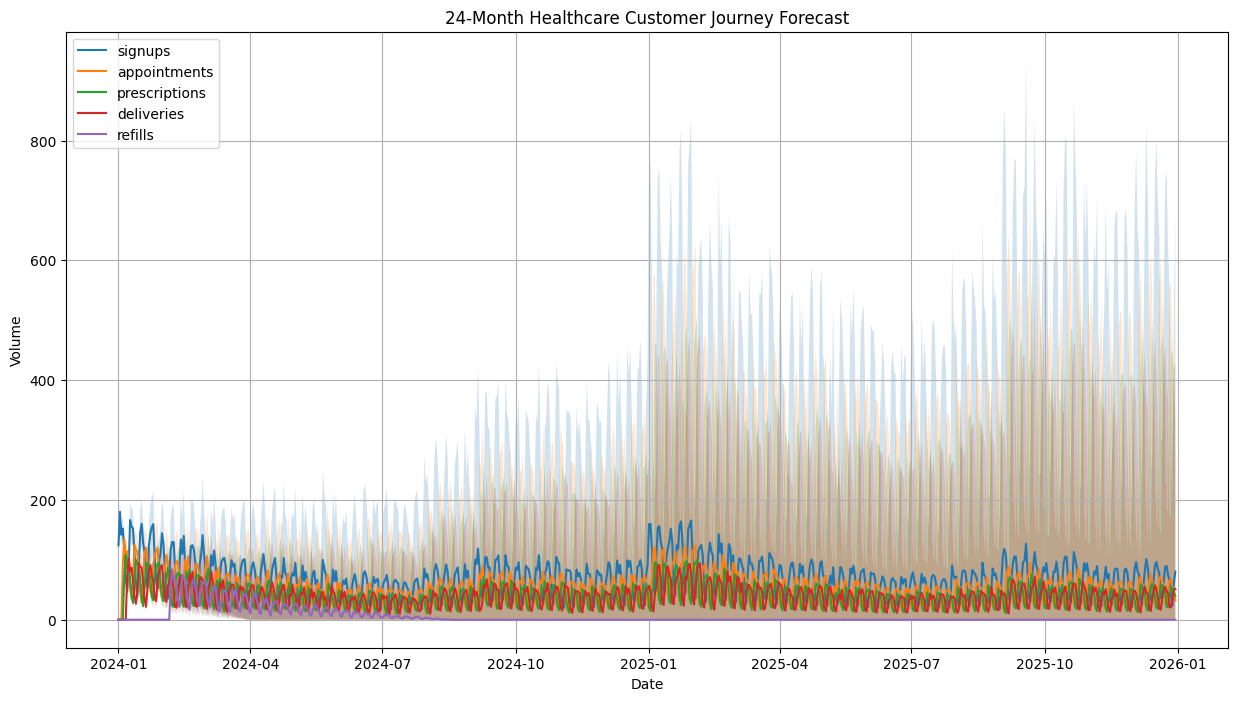


Summary Statistics:
                      date     signups  appointments  prescriptions  \
count                  730  730.000000    730.000000     730.000000   
mean   2024-12-30 12:00:00   69.334481     51.830713      41.429513   
min    2024-01-01 00:00:00   16.774003      0.000000       0.000000   
25%    2024-07-01 06:00:00   41.089021     30.633724      24.266144   
50%    2024-12-30 12:00:00   68.787189     51.551480      41.241184   
75%    2025-06-30 18:00:00   88.707539     66.530654      53.224524   
max    2025-12-30 00:00:00  180.128589    135.096442     108.077153   
std                    NaN   31.875756     24.101244      19.333091   

       deliveries     refills  signups_lower  signups_upper  \
count  730.000000  730.000000     730.000000     730.000000   
mean    39.247878    5.381108       5.694775     319.094275   
min      0.000000    0.000000       0.000000      40.674916   
25%     22.806112    0.000000       0.000000     161.202923   
50%     39.153332    0.0

In [13]:
# Test implementation

# Test results show expected behavior with:
#  January spike visible
#  Stage-to-stage conversion patterns
#  Widening confidence intervals
#  Growing refill volume


import matplotlib.pyplot as plt

# Initialize forecaster
forecaster = HealthcareForecaster(base_daily_signups=100)
start_date = datetime(2024, 1, 1)
forecast = forecaster.generate_forecast(start_date)

# Plot results
plt.figure(figsize=(15, 8))
for col in ['signups', 'appointments', 'prescriptions', 'deliveries', 'refills']:
    plt.plot(forecast['date'], forecast[col], label=col)
    plt.fill_between(forecast['date'], 
                     forecast[f'{col}_lower'], 
                     forecast[f'{col}_upper'], 
                     alpha=0.2)

plt.title('24-Month Healthcare Customer Journey Forecast')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

# Display summary statistics
print("\nSummary Statistics:")
print(forecast.describe())